<a href="https://colab.research.google.com/github/MachineGunLearning/Project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
import os
import cv2
import pickle
import matplotlib.pyplot as plt
from random import shuffle
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve, plot_precision_recall_curve
from keras.wrappers.scikit_learn import KerasClassifier
from google.colab import files


In [3]:
#renaming real and fake directories
real = "/content/drive/My Drive/archive/real_and_fake_face/training_real"
fake = "/content/drive/My Drive/archive/real_and_fake_face/training_fake"
#creating a list of real and fake images
real_path = os.listdir(real)
fake_path = os.listdir(fake)
shuffle(fake_path)

In [4]:
#Preprossesing the dataset; resize, grayscale, adding label
#Splitting 80:20 into training and test
img_size = 128
def create_training_data():
    training_data = []
    for img in tqdm(real_path[:865]):
        path = os.path.join(real, img)
        label = [0] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        training_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[:768]):
        path = os.path.join(fake, img)
        label = [1] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        training_data.append([np.array(image), np.array(label)])

    shuffle(training_data)
    return(training_data)

#Creating a list of test data
def create_test_data():
    test_data = []
    for img in tqdm(real_path[865:]):
        path = os.path.join(real, img)
        label = [0] 
        image = cv2.resize( cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size) )
        test_data.append([np.array(image), np.array(label)])
        
    for img in tqdm(fake_path[768:]):
        path = os.path.join(fake, img)
        label = [1] 
        image = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (img_size,img_size))
        test_data.append([np.array(image), np.array(label)])

    shuffle(test_data)
    return(test_data)

train_data = create_training_data()
test_data = create_test_data()

100%|██████████| 192/192 [01:39<00:00,  1.93it/s]


In [5]:
img_size = 128
#Seperating features and labels, to be able to feed into the model
train_img = []
train_lab = []
test_img = []
test_lab = []

for i in train_data:
    train_img.append(i[0])
    train_lab.append(i[1])
    
for i in test_data:
    test_img.append(i[0])
    test_lab.append(i[1])
    
#Reshape image 
train_img = np.array(train_img).reshape(-1, img_size, img_size, 1)
test_img = np.array(test_img).reshape(-1, img_size, img_size, 1)

#Divide by 255 to squish values to 0 - 1
train_img = train_img/255.0
train_lab = np.array(train_lab)

test_img = test_img/255.0
test_lab = np.array(test_lab)


[[[213]
  [208]
  [211]
  ...
  [141]
  [144]
  [154]]

 [[212]
  [208]
  [209]
  ...
  [141]
  [144]
  [154]]

 [[215]
  [211]
  [209]
  ...
  [139]
  [146]
  [153]]

 ...

 [[198]
  [192]
  [195]
  ...
  [ 21]
  [ 18]
  [ 16]]

 [[199]
  [187]
  [187]
  ...
  [ 21]
  [ 22]
  [ 18]]

 [[203]
  [184]
  [198]
  ...
  [ 27]
  [ 21]
  [ 23]]]
[[[0.83529412]
  [0.81568627]
  [0.82745098]
  ...
  [0.55294118]
  [0.56470588]
  [0.60392157]]

 [[0.83137255]
  [0.81568627]
  [0.81960784]
  ...
  [0.55294118]
  [0.56470588]
  [0.60392157]]

 [[0.84313725]
  [0.82745098]
  [0.81960784]
  ...
  [0.54509804]
  [0.57254902]
  [0.6       ]]

 ...

 [[0.77647059]
  [0.75294118]
  [0.76470588]
  ...
  [0.08235294]
  [0.07058824]
  [0.0627451 ]]

 [[0.78039216]
  [0.73333333]
  [0.73333333]
  ...
  [0.08235294]
  [0.08627451]
  [0.07058824]]

 [[0.79607843]
  [0.72156863]
  [0.77647059]
  ...
  [0.10588235]
  [0.08235294]
  [0.09019608]]]


In [6]:
#Building our CNN model
model = Sequential()

#Layer 1
model.add(Conv2D(64,(3,3), activation="relu", input_shape=(128, 128, 1))) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#Layer 3
model.add(Conv2D(32,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))

#Layer 4
model.add(Conv2D(32,(3,3), activation="relu")) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

#Fully Connected Layer
model.add(Flatten()) 
model.add(Dense(64))

#Output Sigmoid Layer
model.add(Dense(1, activation ="sigmoid"))

opt = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ['accuracy'])

#Training the model
history = model.fit(train_img, train_lab, batch_size = 16, epochs = 50, verbose = 1, validation_split = 0.2)


Epoch 1/50
82/82 [==============================] - 1s 9ms/step - loss: 0.7048 - accuracy: 0.5054 - val_loss: 0.6895 - val_accuracy: 0.5474
Epoch 2/50
82/82 [==============================] - 0s 6ms/step - loss: 0.6846 - accuracy: 0.5559 - val_loss: 0.6870 - val_accuracy: 0.5352
Epoch 3/50
82/82 [==============================] - 0s 6ms/step - loss: 0.6760 - accuracy: 0.6034 - val_loss: 0.6845 - val_accuracy: 0.5566
Epoch 4/50
82/82 [==============================] - 0s 6ms/step - loss: 0.6640 - accuracy: 0.6087 - val_loss: 0.6800 - val_accuracy: 0.5994
Epoch 5/50
82/82 [==============================] - 0s 6ms/step - loss: 0.6498 - accuracy: 0.6294 - val_loss: 0.6837 - val_accuracy: 0.5810
Epoch 6/50
82/82 [==============================] - 0s 6ms/step - loss: 0.6461 - accuracy: 0.6263 - val_loss: 0.6822 - val_accuracy: 0.5933
Epoch 7/50
82/82 [==============================] - 1s 6ms/step - loss: 0.6282 - accuracy: 0.6478 - val_loss: 0.6795 - val_accuracy: 0.5902
Epoch 8/50
82/82 [==

In [7]:
model.save('my_cnn', save_format='tf')

model2 = keras.models.load_model('my_cnn') 
print(model2.summary())

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_cnn/assets
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3

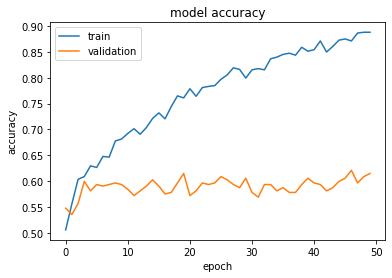

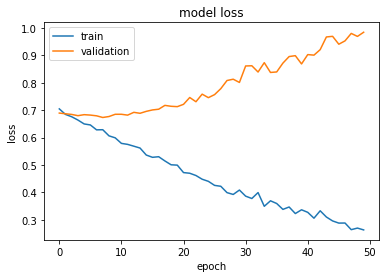

In [11]:
# creating visual representation of training accuracy and loss
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
#Predictions
yhat_probs = model2.predict(test_img, verbose=0)
# predict crisp classes for test set
yhat_classes = model2.predict_classes(test_img, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]

#Printing metrices
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_lab, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_lab, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_lab, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_lab, yhat_classes)
print('F1 score: %f' % f1)
 
# confusion matrix
matrix = confusion_matrix(test_lab, yhat_classes)
print(matrix)

average_precision = average_precision_score(test_lab, yhat_classes)
print(average_precision)


Accuracy: 0.588235
Precision: 0.574074
Recall: 0.484375
F1 score: 0.525424
[[147  69]
 [ 99  93]]
0.5207141884531591
